In [4]:
# Dataset
from sklearn.datasets import load_diabetes

# Basics
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.ensemble import RandomForestRegressor

# Helpful:
from sklearn.model_selection import train_test_split

# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")
# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *

### 1. Load Data

In [3]:
df = pd.read_csv("datasets/energy_data_hourly.csv", index_col="datetime")
df.index = pd.to_datetime(df.index)

In [4]:
# Create the 'weekday' column
df["weekday"] = df.index.day_name()
# Create the 'time' column
df["time"] = df.index.time

In [5]:
df["weekday"] = df["weekday"].astype("category")
df = pd.get_dummies(df, columns=["weekday"], prefix="", prefix_sep="")
df["time"] = df["time"].apply(lambda t: t.hour * 60 + t.minute)

In [60]:
df.head()

,total_energy_usage,residual_energy_usage,pump_storage,time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
datetime,,,,,,,,,,,
2015-01-01 00:00:00,44.601,35.957,602.0,0,0,0,0,0,1,0,0
2015-01-01 01:00:00,43.455,34.642,347.0,60,0,0,0,0,1,0,0
2015-01-01 02:00:00,41.964,32.910,522.0,120,0,0,0,0,1,0,0
2015-01-01 03:00:00,40.618,31.548,1229.0,180,0,0,0,0,1,0,0
2015-01-01 04:00:00,39.936,30.775,1821.0,240,0,0,0,0,1,0,0


### 2. Train Test Split

In [10]:
df.shape

(68184, 11)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[0:1000, 1:].to_numpy(),
    df["total_energy_usage"].iloc[0:1000].to_numpy(),
    test_size=0.2,
    shuffle=False,
)

In [19]:
X_train.shape

(800, 10)

### 3. Random Forest

In [20]:
bootstrap = True
max_sample = 0.7

In [21]:
rf = RandomForestRegressor(
    bootstrap=bootstrap, max_samples=max_sample, verbose=0, n_jobs=-1
)

In [22]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_samples=0.7, n_jobs=-1)

### 3. Calculate Weights Random Forest

In [23]:
rf_weights = calc_weights_rf(rf, X_train, X_test, bootstrap, max_sample)

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.70it/s]


In [ ]:
np.save("/home/dchen/Random_Forest_Weights/data/rf_weights/energy_data/rf_weights_True_0_7.npy", rf_weights)

### 4. Calc Mean with weights and normal:

In [ ]:
rf_weights = np.load("/home/dchen/Random_Forest_Weights/data/rf_weights/energy_data/rf_weights_True_0_7.npy")

In [24]:
rf_mean_weights = calc_mean_rf(rf_weights, y_train)
rf_mean_normal = rf.predict(X_test)

In [25]:
# Are the two the same?
sum(np.round(rf_mean_weights, 5) == np.round(rf_mean_normal, 5))

200

### 5. Calc Quantile Random Forest

In [26]:
rf_cdfs = calc_dist_rf(rf_weights, y_train)

In [27]:
rf_median = calc_quantile_rf(rf_cdfs, 0.5, y_train)

In [28]:
rf_median[:10]

[72.94300000000071,
 73.18700000000109,
 73.90900000000012,
 74.62454687500001,
 68.76600000000063,
 65.57700000000109,
 63.47700000000073,
 68.76600000000063,
 71.75099999999938,
 72.9529765625]

### 6. Weights Analysis


In [29]:
rf_weights.shape

(100, 200, 800)

<AxesSubplot:>

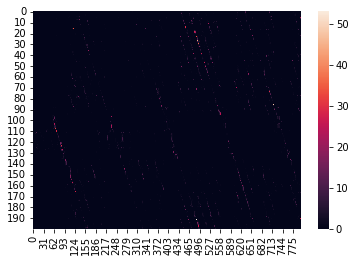

In [57]:
sns.heatmap(np.sum(rf_weights, axis = 0))

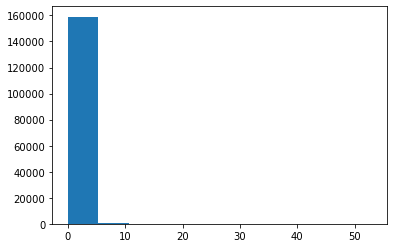

In [61]:
plt.hist(np.sum(rf_weights, axis = 0).flatten(), bins = 10)
plt.show()

In [63]:
np.mean(rf_weights, axis = 0).shape

(200, 800)

In [66]:
np.max(np.sum(rf_weights, axis = 0))

53.0

In [40]:
np.sum(rf_weights[0].flatten() == 1)

200

In [34]:
X_train.shape

(800, 10)

In [45]:
rf_weights[0,0].sum()

1.0

In [51]:
rf.estimators_[0]

DecisionTreeRegressor(max_features='auto', random_state=797139370)